<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/LRIM_TransferLearning_sigma0_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:

nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Plot function

In [3]:
def avg_prob(unique_temperatures, predictions, temperatures):
  # Initialize an array to store average prediction probabilities for each unique temperature
  average_probabilities = np.zeros_like(unique_temperatures, dtype=float)

  # Calculate average prediction probability for each unique temperature
  for i, temp in enumerate(unique_temperatures):
      # Find indices corresponding to the current unique temperature
      temp_indices = np.where(temperatures == temp)
      # Extract prediction probabilities for these indices
      temp_predictions = predictions[temp_indices]
      # Calculate average prediction probability
      average_prob = np.mean(temp_predictions)
      # Store the average probability
      average_probabilities[i] = average_prob
  return average_probabilities

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predictions' is the array containing prediction probabilities
# and 'temperatures' is the array containing corresponding temperatures
def plot_proba(temperatures, predictions1, predictions2, label1 = 'Ordered state', label2 = 'Disordered state'):
# Calculate unique temperature values and their corresponding indices
  unique_temperatures, indices = np.unique(temperatures, return_inverse=True)
  avg_proba1 = avg_prob(unique_temperatures, predictions1, temperatures)
  avg_proba2 = avg_prob(unique_temperatures, predictions2, temperatures)

  # Plot the average prediction probabilities against temperature
  plt.figure(figsize=(8, 6))
  plt.plot(unique_temperatures, avg_proba1, marker='o', linestyle='-', label = label1)
  plt.plot(unique_temperatures, avg_proba2, marker='o', linestyle='-', label = label2)
  plt.legend()
  plt.xlabel('Temperature')
  plt.ylabel('Average Prediction Probability')
  plt.title('Average Prediction Probability per Temperature')

  plt.grid(True)
  plt.show()


### Concatenate npz files

In [5]:
def combine_npz_files(file1, file2, combined_file):
    # Load data and labels from the first .npz file
    data1 = np.load(file1)['X']
    labels1 = np.load(file1)['y']

    # Load data and labels from the second .npz file
    data2 = np.load(file2)['X']
    labels2 = np.load(file2)['y']

    # Concatenate data and labels along the appropriate axis
    combined_data = np.concatenate((data1, data2), axis=0)
    combined_labels = np.concatenate((labels1, labels2), axis=0)

    # Save the combined data and labels into a new .npz file
    np.savez(combined_file, X=combined_data, y=combined_labels)

### Model

#### Accuracy, train and test functions

In [6]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [7]:
import numpy as np

def calculate_accuracy_np(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).astype(float)

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape

    # Calculate the number of correct predictions
    correct = np.sum(predicted == labels).astype(float) / 2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.shape[0]

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [70]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  model.train()
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 2 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [9]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [263]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    model.eval()
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [11]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [12]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms

# Define a function to generate rotated data
def rotate_data(X):
    rotated_X = torch.rot90(X, k=1, dims=(0, 1))  # Rotate data by 90 degrees clockwise
    return rotated_X

# Modify the dataset to include both original and rotated data
def create_combined_dataset_with_augmentation(original_dataset):
    combined_dataset = []
    for X, Y in original_dataset:
        rotated_X = rotate_data(X)
        combined_dataset.append((X, Y))  # Add original data
        combined_dataset.append((rotated_X, Y))  # Add rotated data
    return combined_dataset

In [13]:
def create_combined_dataset(dataset1, dataset2):
    combined_dataset = []
    for X, Y in dataset1:
        combined_dataset.append((X, Y))  # Add original data
    for X, Y in dataset2:
        combined_dataset.append((X, Y))  # Add original data
    return combined_dataset

In [51]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    # Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [52]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [16]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


In [17]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader named original_dataloader
# Define a new DataLoader class to subset the original DataLoader
class SubsetDataLoader(DataLoader):
    def __init__(self, dataloader, num_batches):
        super(SubsetDataLoader, self).__init__(dataloader.dataset, batch_size=dataloader.batch_size)
        self.dataloader = dataloader
        self.num_batches = num_batches
        self.current_batch = 0

    def __iter__(self):
        self.current_batch = 0
        self.dataloader_iter = iter(self.dataloader)
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        self.current_batch += 1
        return next(self.dataloader_iter)

Train and test data:

In [18]:
# # Anti-ferromagnetic dataset: train and test

# X_train, X_test, y_train, y_test, Y_train, Y_test = file_loader('data.npz')

In [19]:
# training_dataset = IsingDataset(X_train, y_train)
# testing_dataset = IsingDataset(X_test, y_test)
# batch_size = 128
# train_dataloader = DataLoader(dataset = training_dataset, batch_size = batch_size, shuffle = False)
# test_dataloader = DataLoader(dataset = testing_dataset, batch_size = batch_size, shuffle = False)

In [20]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data.npz')

In [21]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Class: [0. 1.]
Temperature: 2.9000000000000004


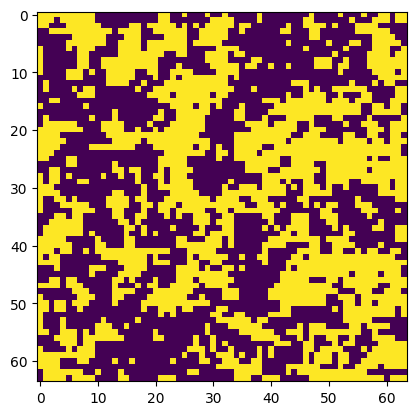

In [22]:
plt.imshow(X_train_anti[30])
print("Class:", y_train_anti[30])
print("Temperature:", Y_train_anti[30])

#### CNN:

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet_for(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [27]:
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [28]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

Loss: 0.694180428981781 ,Train accuracy: 0.5546875
Loss: 0.091684490442276 ,Train accuracy: 0.96875
Loss: 0.0309482142329216 ,Train accuracy: 0.9921875
Loss: 0.05860332399606705 ,Train accuracy: 0.984375
Loss: 0.05501620098948479 ,Train accuracy: 0.9765625
Loss: 0.06583795696496964 ,Train accuracy: 0.96875
Loss: 0.03266631066799164 ,Train accuracy: 0.984375
Loss: 0.010611946694552898 ,Train accuracy: 1.0
Loss: 0.06847458332777023 ,Train accuracy: 0.9765625
Loss: 0.03438694402575493 ,Train accuracy: 0.9921875
Loss: 0.03491698578000069 ,Train accuracy: 0.9921875
Loss: 0.014724770560860634 ,Train accuracy: 0.9921875
Loss: 0.015350587666034698 ,Train accuracy: 0.9921875
Loss: 0.0418313592672348 ,Train accuracy: 0.9765625
Loss: 0.04304971545934677 ,Train accuracy: 0.9765625
Loss: 0.015512876212596893 ,Train accuracy: 1.0
Loss: 0.030398424714803696 ,Train accuracy: 0.9921875
Loss: 0.059331782162189484 ,Train accuracy: 0.9765625
Loss: 0.028810463845729828 ,Train accuracy: 0.984375
Loss: 0.025

In [29]:
test(CNN, criterion_CNN, test_dataloader_anti)

0 :: Loss: 0.002001099521294236 ,Test accuracy: 1.0
1 :: Loss: 0.0010269650956615806 ,Test accuracy: 1.0
2 :: Loss: 0.016443293541669846 ,Test accuracy: 0.9921875
3 :: Loss: 0.016720939427614212 ,Test accuracy: 0.9921875
4 :: Loss: 0.03182162344455719 ,Test accuracy: 0.9765625
5 :: Loss: 0.0119164464995265 ,Test accuracy: 0.9921875
6 :: Loss: 0.10629545152187347 ,Test accuracy: 0.9921875
7 :: Loss: 0.02815145254135132 ,Test accuracy: 0.9921875
8 :: Loss: 0.04754095524549484 ,Test accuracy: 0.9921875
9 :: Loss: 0.014696341939270496 ,Test accuracy: 0.9921875
10 :: Loss: 0.010660064406692982 ,Test accuracy: 1.0
11 :: Loss: 0.002374469768255949 ,Test accuracy: 1.0
12 :: Loss: 0.030262451618909836 ,Test accuracy: 0.9921875
13 :: Loss: 0.0038443137891590595 ,Test accuracy: 1.0
14 :: Loss: 0.040764905512332916 ,Test accuracy: 0.984375
15 :: Loss: 0.011587338522076607 ,Test accuracy: 1.0
16 :: Loss: 0.03969980776309967 ,Test accuracy: 0.9921875
17 :: Loss: 0.0951177254319191 ,Test accuracy: 0.

In [30]:
torch.save(CNN.state_dict(), 'CNN_anti.pth')

### CNN 2

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet2(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0)
        self.max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.out_conv2 = self._calculate_output_size(self.out_conv1, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(9216, 64)  # Adjusted input size for fc1
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = self.max_pool_layer(F.relu(self.conv1(x)))
        x = self.max_pool_layer(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

# Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

# Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [32]:
CNN_2 = ConvNet2(Nx, Ny).to(device)
criterion_CNN_2 = nn.BCELoss()
optimizer_CNN_2 = optim.Adam(CNN_2.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [33]:
train(CNN_2, 10, criterion_CNN_2, optimizer_CNN_2, train_dataloader_anti)

Loss: 0.6858808398246765 ,Train accuracy: 0.671875
Loss: 0.26490074396133423 ,Train accuracy: 0.96875
Loss: 0.02777155116200447 ,Train accuracy: 1.0
Loss: 0.01879196986556053 ,Train accuracy: 0.9921875
Loss: 0.08497613668441772 ,Train accuracy: 0.96875
Loss: 0.03263227641582489 ,Train accuracy: 0.9921875
Loss: 0.012102596461772919 ,Train accuracy: 0.9921875
Loss: 0.016618140041828156 ,Train accuracy: 1.0
Loss: 0.04262743890285492 ,Train accuracy: 0.984375
Loss: 0.039221424609422684 ,Train accuracy: 0.9921875
Loss: 0.04507254809141159 ,Train accuracy: 0.984375
Loss: 0.0023563141003251076 ,Train accuracy: 1.0
Loss: 0.009854448959231377 ,Train accuracy: 1.0
Loss: 0.04992075264453888 ,Train accuracy: 0.9765625
Loss: 0.02676323428750038 ,Train accuracy: 0.9921875
Loss: 0.006158291362226009 ,Train accuracy: 1.0
Loss: 0.01574324630200863 ,Train accuracy: 0.9921875
Loss: 0.05229845270514488 ,Train accuracy: 0.9765625
Loss: 0.040618330240249634 ,Train accuracy: 0.984375
Loss: 0.0313096567988395

In [34]:
test(CNN_2, criterion_CNN_2, test_dataloader_anti)

0 :: Loss: 0.000864170491695404 ,Test accuracy: 1.0
1 :: Loss: 0.0010691341012716293 ,Test accuracy: 1.0
2 :: Loss: 0.0038888948038220406 ,Test accuracy: 1.0
3 :: Loss: 0.010985901579260826 ,Test accuracy: 0.9921875
4 :: Loss: 0.03735170513391495 ,Test accuracy: 0.9921875
5 :: Loss: 0.019228115677833557 ,Test accuracy: 0.984375
6 :: Loss: 0.035684019327163696 ,Test accuracy: 0.9921875
7 :: Loss: 0.0161492507904768 ,Test accuracy: 0.9921875
8 :: Loss: 0.004515614826232195 ,Test accuracy: 1.0
9 :: Loss: 0.007624246180057526 ,Test accuracy: 0.9921875
10 :: Loss: 0.001673333696089685 ,Test accuracy: 1.0
11 :: Loss: 0.0005465545691549778 ,Test accuracy: 1.0
12 :: Loss: 0.012964227236807346 ,Test accuracy: 0.9921875
13 :: Loss: 0.001207627821713686 ,Test accuracy: 1.0
14 :: Loss: 0.04750431329011917 ,Test accuracy: 0.984375
15 :: Loss: 0.005758853629231453 ,Test accuracy: 1.0
16 :: Loss: 0.016678208485245705 ,Test accuracy: 0.9921875
17 :: Loss: 0.02184533141553402 ,Test accuracy: 0.984375
1

In [35]:
torch.save(CNN_2.state_dict(), 'CNN_anti.pth')

### Transfer Learning

#### Loading the Dataset

Full Data

In [53]:
X2, y2, Y2 = full_file_loader('LRIM_FT_64L_maxepochs_M.npz', 9.1)

In [54]:
dataset2 = IsingDataset(X2, y2)
batch_size = 128
dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Train and test data

In [55]:
X_train2, X_test2, y_train2, y_test2, Y_train2, Y_test2 = file_loader('LRIM_FT_64L_maxepochs_M.npz', 9.1)

In [56]:
training_dataset2 = IsingDataset(X_train2, y_train2)
testing_dataset2 = IsingDataset(X_test2, y_test2)
batch_size = 128
train_dataloader2 = DataLoader(dataset = training_dataset2, batch_size = batch_size, shuffle = False)
test_dataloader2 = DataLoader(dataset = testing_dataset2, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


#### Training a model to compare the results

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

CNN2 = ConvNet2(Nx, Ny)
CNN2.to(device)

# Setup optimizer
optimizer = optim.Adam(CNN2.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# Example usage of the training function with dataloader8
train(CNN2, num_epochs=50, criterion=criterion, optimizer=optimizer, train_dataloader=train_dataloader2)
# train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=dataset34)

Loss: 0.6464437246322632 ,Train accuracy: 0.875
Loss: 0.23013918101787567 ,Train accuracy: 0.8828125
Loss: 0.24407844245433807 ,Train accuracy: 0.8828125
Loss: 0.18877343833446503 ,Train accuracy: 0.8828125
Loss: 0.16394631564617157 ,Train accuracy: 0.8828125
Loss: 0.1416999101638794 ,Train accuracy: 0.8828125
Loss: 0.13219653069972992 ,Train accuracy: 0.8828125
Loss: 0.12541964650154114 ,Train accuracy: 0.8828125
Loss: 0.12052565813064575 ,Train accuracy: 0.8828125
Loss: 0.11630047112703323 ,Train accuracy: 0.8828125
Loss: 0.11378446221351624 ,Train accuracy: 0.8828125
Loss: 0.11782193928956985 ,Train accuracy: 0.8828125
Loss: 0.11365676671266556 ,Train accuracy: 0.8828125
Loss: 0.11292611807584763 ,Train accuracy: 0.8828125
Loss: 0.109126016497612 ,Train accuracy: 0.8828125
Loss: 0.10601448267698288 ,Train accuracy: 0.8828125
Loss: 0.1087944358587265 ,Train accuracy: 0.8828125
Loss: 0.10630901902914047 ,Train accuracy: 0.8828125
Loss: 0.1064770519733429 ,Train accuracy: 0.8828125
Los

In [41]:
test(CNN2, criterion, test_dataloader2)

0 :: Loss: 0.052144426852464676 ,Test accuracy: 0.9375
1 :: Loss: 0.104607492685318 ,Test accuracy: 0.865979381443299


In [42]:
pred_class1, pred_class2 = get_predictions(train_dataloader2, CNN2)

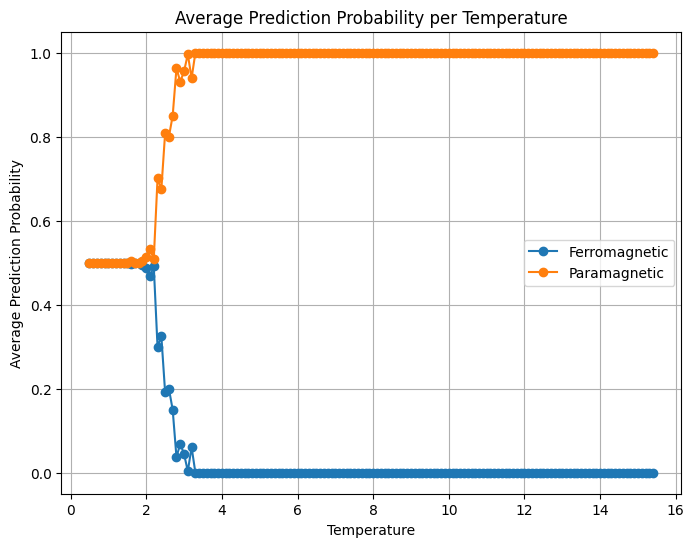

In [43]:
plot_proba(np.array(Y_train2), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

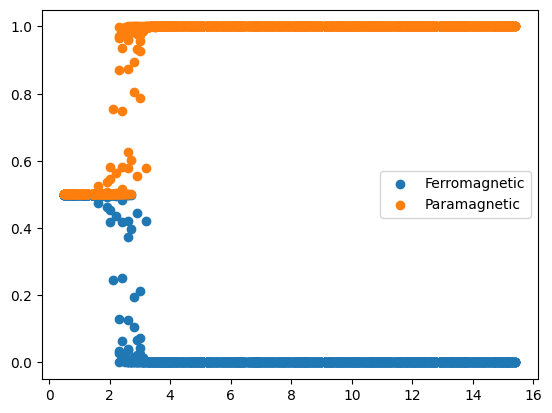

In [44]:
plt.scatter(Y_train2, pred_class1, label='Ferromagnetic')
plt.scatter(Y_train2, pred_class2, label='Paramagnetic')
plt.legend()

In [ ]:
y_comb1234 = np.array([item[1] for item in combined_dataloader_wo_aug1234.dataset])

In [ ]:
calculate_accuracy_np(np.column_stack((pred_class1, pred_class2)), y_comb1234)

0.9558888888888889

#### Transfer learning on NNN R=+2 data, model pre-trained on Ferro NN

##### Both weights not initialized:

In [170]:
X2_filter = X2[(Y2 < 10.0) & (Y2 > 8.0)]
y2_filter = y2[(Y2 < 10.0) & (Y2 > 8.0)]
Y2_filter = Y2[(Y2 < 10.0) & (Y2 > 8.0)]

dataset2_filter = IsingDataset(X2_filter, y2_filter)
batch_size = 128
dataloader2_filter = DataLoader(dataset = dataset2_filter, batch_size = batch_size, shuffle = False)

<ipython-input-16-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-16-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


For Tc=8.9

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
model2.conv1.weight.requires_grad = True
model2.conv1.bias.requires_grad = True
model2.conv2.weight.requires_grad = True
model2.conv2.bias.requires_grad = True
model2.conv3.weight.requires_grad = True
model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=6*1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# lr=3*1e-4 and 6*1e-4, num_epochs=40,50,60 all worked (6e-4 and 60 worked well -> Tc=8.8)
# Example usage of the training function with dataloader8
train(model2, num_epochs=40, criterion=criterion, optimizer=optimizer, train_dataloader=dataloader2)
train(model2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=dataloader2_filter)

<ipython-input-306-4761ff82a583>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("CNN_anti.pth")


Loss: 2.4746052531554596e-06 ,Train accuracy: 1.0
Loss: 3.1495580969931325e-06 ,Train accuracy: 1.0
Loss: 1.7694113921606913e-05 ,Train accuracy: 1.0
Loss: 24.79972267150879 ,Train accuracy: 0.203125
Loss: 4.263314622221515e-06 ,Train accuracy: 1.0
Loss: 1.1980051567661576e-05 ,Train accuracy: 1.0
Loss: 2.490993522563656e-10 ,Train accuracy: 1.0
Loss: 3.787543167987906e-09 ,Train accuracy: 1.0
Loss: 2.455193168771075e-07 ,Train accuracy: 1.0
Loss: 4.05061149597168 ,Train accuracy: 0.34375
Loss: 0.3611873388290405 ,Train accuracy: 0.8515625
Loss: 0.31042173504829407 ,Train accuracy: 0.8828125
Loss: 1.6592265061898814e-10 ,Train accuracy: 1.0
Loss: 1.4173009987850094e-10 ,Train accuracy: 1.0
Loss: 2.6006608422335376e-08 ,Train accuracy: 1.0
Loss: 3.5237796306610107 ,Train accuracy: 0.3359375
Loss: 0.06041191518306732 ,Train accuracy: 0.9765625
Loss: 0.04250132665038109 ,Train accuracy: 0.9765625
Loss: 3.146589933056276e-11 ,Train accuracy: 1.0
Loss: 3.3284879640362898e-15 ,Train accuracy

In [307]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate average probability at each unique temperature
def avg_prob(unique_temperatures, predictions, temperatures):
    avg_probs = []
    for T in unique_temperatures:
        avg_probs.append(np.mean(predictions[temperatures == T]))
    return np.array(avg_probs)

# Function to plot probabilities with intersection point
def plot_proba(temperatures, predictions1, predictions2, label1='Ordered state', label2='Disordered state'):
    # Get unique temperatures and their average probabilities
    unique_temperatures = np.sort(np.unique(temperatures))
    avg_proba1 = avg_prob(unique_temperatures, predictions1, temperatures)
    avg_proba2 = avg_prob(unique_temperatures, predictions2, temperatures)

    # Find the intersection point (where probabilities are closest)
    diff = np.abs(avg_proba1 - avg_proba2)
    Tc_index = np.argmin(diff)  # Index of closest probability difference
    Tc = unique_temperatures[Tc_index]  # Temperature at intersection

    # Plot the average prediction probabilities
    plt.figure(figsize=(8, 6))
    plt.plot(unique_temperatures, avg_proba1, marker='o', linestyle='-', label=label1)
    plt.plot(unique_temperatures, avg_proba2, marker='o', linestyle='-', label=label2)

    # Mark the intersection point
    plt.axvline(x=Tc, color='black', linestyle='--', label=f"Tc ≈ {Tc:.2f}")
    plt.scatter([Tc], [avg_proba1[Tc_index]], color='black', zorder=3)

    # Labels and title
    plt.xlabel('Temperature', fontsize=14)
    plt.ylabel('Average Prediction Probability', fontsize=14)
    plt.title('Average Prediction Probability per Temperature', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_proba(np.array(Y2), np.array(pred_class1), np.array(pred_class2))


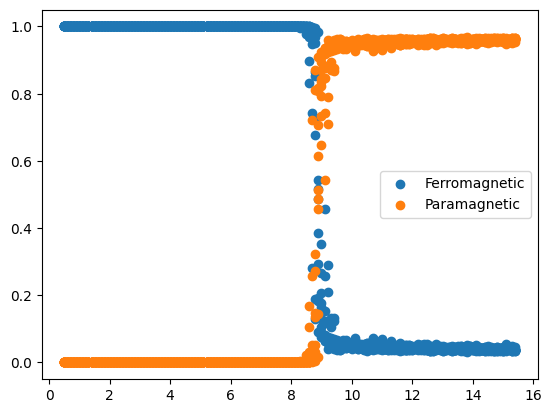

In [308]:
pred_class1, pred_class2 = get_predictions(dataloader2, model2)
plt.scatter(Y2, pred_class1, label='Ferromagnetic')
plt.scatter(Y2, pred_class2, label='Paramagnetic')
plt.legend()

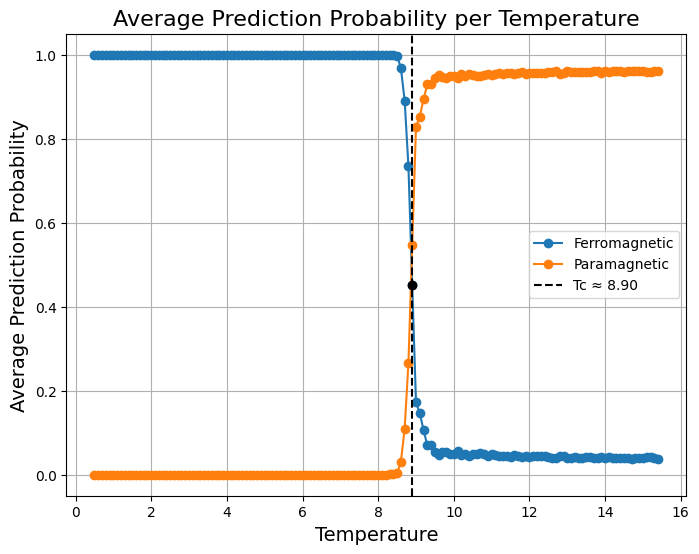

In [309]:
plot_proba(np.array(Y2), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

Exploring hyperparameters

In [316]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model2 = ConvNet2(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet2(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model2.conv1.weight.data = pretrained_model.conv1.weight.data
model2.conv1.bias.data = pretrained_model.conv1.bias.data
model2.conv2.weight.data = pretrained_model.conv2.weight.data
model2.conv2.bias.data = pretrained_model.conv2.bias.data
model2.conv3.weight.data = pretrained_model.conv3.weight.data
model2.conv3.bias.data = pretrained_model.conv3.bias.data
####
model2.fc1.weight.data = pretrained_model.fc1.weight.data
model2.fc1.bias.data = pretrained_model.fc1.bias.data

model2.fc2.weight.data = pretrained_model.fc2.weight.data
model2.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model2.fc1.weight.requires_grad = True
model2.fc1.bias.requires_grad = True
model2.fc2.weight.requires_grad = True
model2.fc2.bias.requires_grad = True
model2.conv1.weight.requires_grad = True
model2.conv1.bias.requires_grad = True
model2.conv2.weight.requires_grad = True
model2.conv2.bias.requires_grad = True
model2.conv3.weight.requires_grad = True
model2.conv3.bias.requires_grad = True

model2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=3*1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()

# lr=3*1e-4 and 6*1e-4, num_epochs=40,50,60 all worked (6e-4 and 60 worked well -> Tc=8.8)
# Example usage of the training function with dataloader8
train(model2, num_epochs=40, criterion=criterion, optimizer=optimizer, train_dataloader=dataloader2)


<ipython-input-316-1f958a7c54ca>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("CNN_anti.pth")


Loss: 5.158442036190536e-06 ,Train accuracy: 1.0
Loss: 4.829081262869295e-06 ,Train accuracy: 1.0
Loss: 8.390408038394526e-05 ,Train accuracy: 1.0
Loss: 29.381364822387695 ,Train accuracy: 0.203125
Loss: 1.0210387699771672e-06 ,Train accuracy: 1.0
Loss: 7.527406751250965e-07 ,Train accuracy: 1.0
Loss: 1.6049835949161206e-06 ,Train accuracy: 1.0
Loss: 4.29685030667315e-07 ,Train accuracy: 1.0
Loss: 1.0573063264018856e-05 ,Train accuracy: 1.0
Loss: 16.38692855834961 ,Train accuracy: 0.203125
Loss: 3.933870539185591e-05 ,Train accuracy: 1.0
Loss: 7.361057214438915e-05 ,Train accuracy: 1.0
Loss: 1.3796491202811012e-06 ,Train accuracy: 1.0
Loss: 1.3357314365691764e-08 ,Train accuracy: 1.0
Loss: 9.848702120507369e-07 ,Train accuracy: 1.0
Loss: 5.0457763671875 ,Train accuracy: 0.3046875
Loss: 0.023029454052448273 ,Train accuracy: 1.0
Loss: 0.1978570967912674 ,Train accuracy: 0.953125
Loss: 7.330741569333554e-10 ,Train accuracy: 1.0
Loss: 1.2090680456822156e-08 ,Train accuracy: 1.0
Loss: 7.296

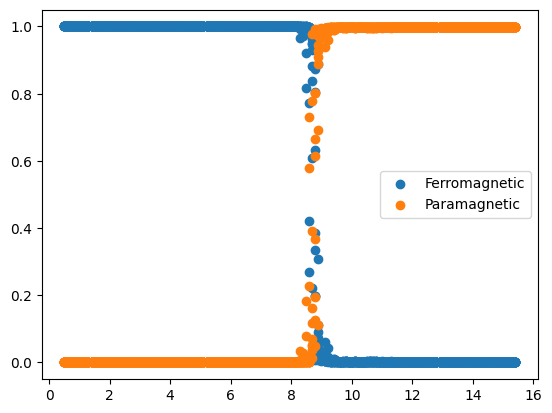

In [317]:
pred_class1, pred_class2 = get_predictions(dataloader2, model2)
plt.scatter(Y2, pred_class1, label='Ferromagnetic')
plt.scatter(Y2, pred_class2, label='Paramagnetic')
plt.legend()

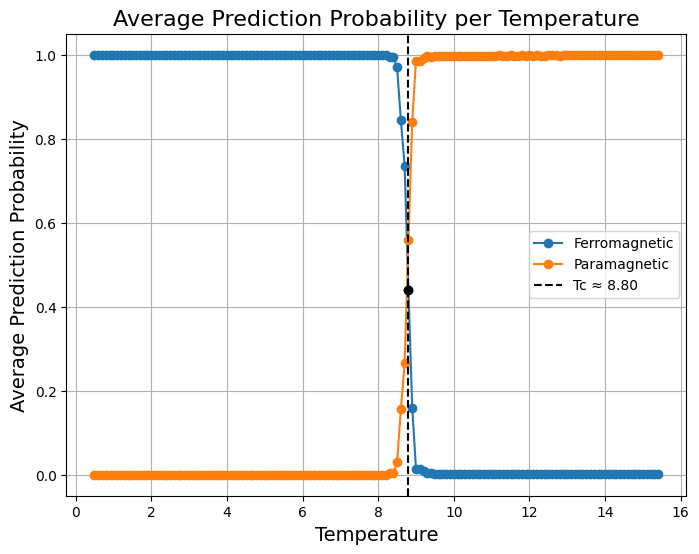

In [318]:
plot_proba(np.array(Y2), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

In [319]:
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=1*1e-4, betas=[0.9,0.999])
train(model2, num_epochs=24, criterion=criterion, optimizer=optimizer, train_dataloader=dataloader2_filter)

Loss: 1.1982100009918213 ,Train accuracy: 0.7109375
Loss: 0.8534985780715942 ,Train accuracy: 0.7421875
Loss: 0.5200448036193848 ,Train accuracy: 0.78125
Loss: 0.6481658220291138 ,Train accuracy: 0.75
Loss: 0.4346246123313904 ,Train accuracy: 0.796875
Loss: 0.6648215055465698 ,Train accuracy: 0.8125
Loss: 0.5874972343444824 ,Train accuracy: 0.8046875
Loss: 0.5236960649490356 ,Train accuracy: 0.7890625
Loss: 0.7332783341407776 ,Train accuracy: 0.734375
Loss: 0.7044795751571655 ,Train accuracy: 0.78125
Loss: 0.5885187387466431 ,Train accuracy: 0.7734375
Loss: 0.5969269275665283 ,Train accuracy: 0.8046875
Loss: 0.7048454284667969 ,Train accuracy: 0.765625
Loss: 0.5878933668136597 ,Train accuracy: 0.8203125
Loss: 0.6271549463272095 ,Train accuracy: 0.765625
Loss: 0.5692610740661621 ,Train accuracy: 0.78125
Loss: 0.6939743757247925 ,Train accuracy: 0.765625
Loss: 0.4183826744556427 ,Train accuracy: 0.8046875
Loss: 0.44122833013534546 ,Train accuracy: 0.8203125
Loss: 0.6237325668334961 ,Trai

In [364]:
optimizer = optim.Adam([
    {'params': model2.fc1.parameters()},
    {'params': model2.fc2.parameters()}
], lr=3*1e-10, betas=[0.9,0.999])
train(model2, num_epochs=5, criterion=criterion, optimizer=optimizer, train_dataloader=dataloader2_filter)

Loss: 0.3682434856891632 ,Train accuracy: 0.8359375
Loss: 0.35947519540786743 ,Train accuracy: 0.828125
Loss: 0.3658812940120697 ,Train accuracy: 0.8359375
Loss: 0.4019022285938263 ,Train accuracy: 0.8203125
Loss: 0.3458600640296936 ,Train accuracy: 0.828125


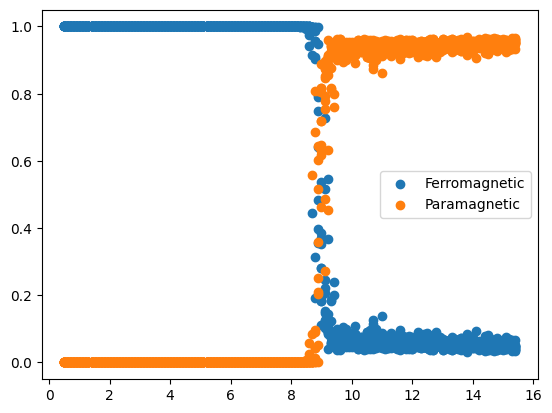

In [365]:
pred_class1, pred_class2 = get_predictions(dataloader2, model2)
plt.scatter(Y2, pred_class1, label='Ferromagnetic')
plt.scatter(Y2, pred_class2, label='Paramagnetic')
plt.legend()

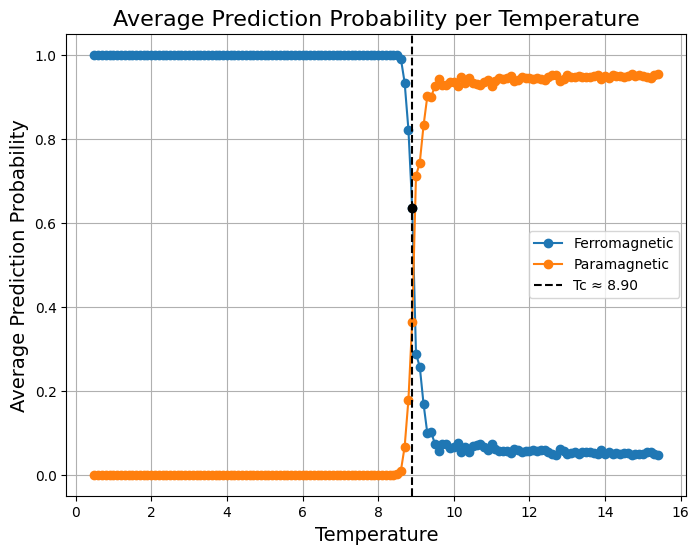

In [366]:
plot_proba(np.array(Y2), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')